### Can tidal forces and the Lidov-Kozai mechanism cause a system of exomoons to align in the same orbital plane?

In [1]:
# packages
import numpy as np
from amuse.lab import Particles
import matplotlib.pyplot as plt
from amuse.units.constants import G
from amuse.units import units, constants
from amuse.lab import Huayno, nbody_system
from amuse.community.ph4.interface import ph4
from amuse.units import generic_unit_converter
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.ext.orbital_elements import new_binary_from_orbital_elements

In [2]:
def sun_jup_gan():
    
    Msun = 1.0|units.MSun
    Mjup = 1.0|units.MJupiter
    a_jup = 5.2|units.au
    e_jup = 0.0
    
    system = new_binary_from_orbital_elements(Msun, Mjup, a_jup, e_jup, G=constants.G)
    system[0].name = 'sun'
    system[1].name = 'jupiter'
    jupiter = system[system.name=='jupiter']
    jupiter.semimajor_axis = a_jup
    
    a_gan = 1070400|units.km
    e_gan = 0.6
    i_gan = 60|units.deg
    Mgan = 1.48E23|units.kg
    binary = new_binary_from_orbital_elements(jupiter.mass, Mgan, a_gan, eccentricity=e_gan, inclination=i_gan, G=constants.G)
    
    ganymede = binary[1].as_set()
    system.add_particle(binary[1])
    system[2].name = 'ganymede'
    ganymede = system[system.name=='ganymede']  
    
    ganymede.semimajor_axis = a_gan
    ganymede.inclination = i_gan
    ganymede.position = binary[1].position + jupiter.position
    ganymede.velocity = binary[1].velocity + jupiter.velocity
    
    system.move_to_center()
    
    return system

system = sun_jup_gan()

In [49]:
# Integrate system over time
def integrate_system(dt, end_time):
    
    system = sun_jup_gan()
    
    convert_nbody = nbody_system.nbody_to_si(system.mass.sum(), system[1].position.length())
    
    gravity = Huayno(convert_nbody)
    gravity.particles.add_particles(system)
    
    ecc = [] #eccentricity
    inc = [] | units.deg #inclination
    time = [] | units.yr
    
    channel = gravity.particles.new_channel_to(system)
    
    while gravity.model_time < end_time:
        
        orbit_ganymede = get_orbital_elements_from_binary(system[1:3], G=constants.G)
        
        gravity.evolve_model(gravity.model_time + (dt))
        channel.copy()
        
        ecc.append(orbit_ganymede[3])
        inc.append(orbit_ganymede[5])
        time.append(gravity.model_time + (dt))
        
    gravity.stop()
    
    return ecc, inc, time

In [50]:
ecc, inc, time = integrate_system(10|units.yr, 2000|units.yr)

In [51]:
# eccentricity as function of the orbital inclination
def plot_track(ecc, inc, time):
    
    #plt.rcdefaults()
    plt.rcParams.update({'font.size': 20})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 10], facecolor='white')
    fig.suptitle('Huayno code (dt=10yrs)')
    
    ax1.plot(time.value_in(units.yr), inc.value_in(units.deg), '-o', color='b', lw=2)
    ax1.set_ylabel('Inclination [deg]')
    ax1.set_xlabel('Time [years]')
    
    ax2.plot(time.value_in(units.yr), np.array(ecc), '-o', color='b', lw=2)
    ax2.set_ylabel('Eccentricity')
    ax2.set_xlabel('Time [years]')
   
    plt.show()

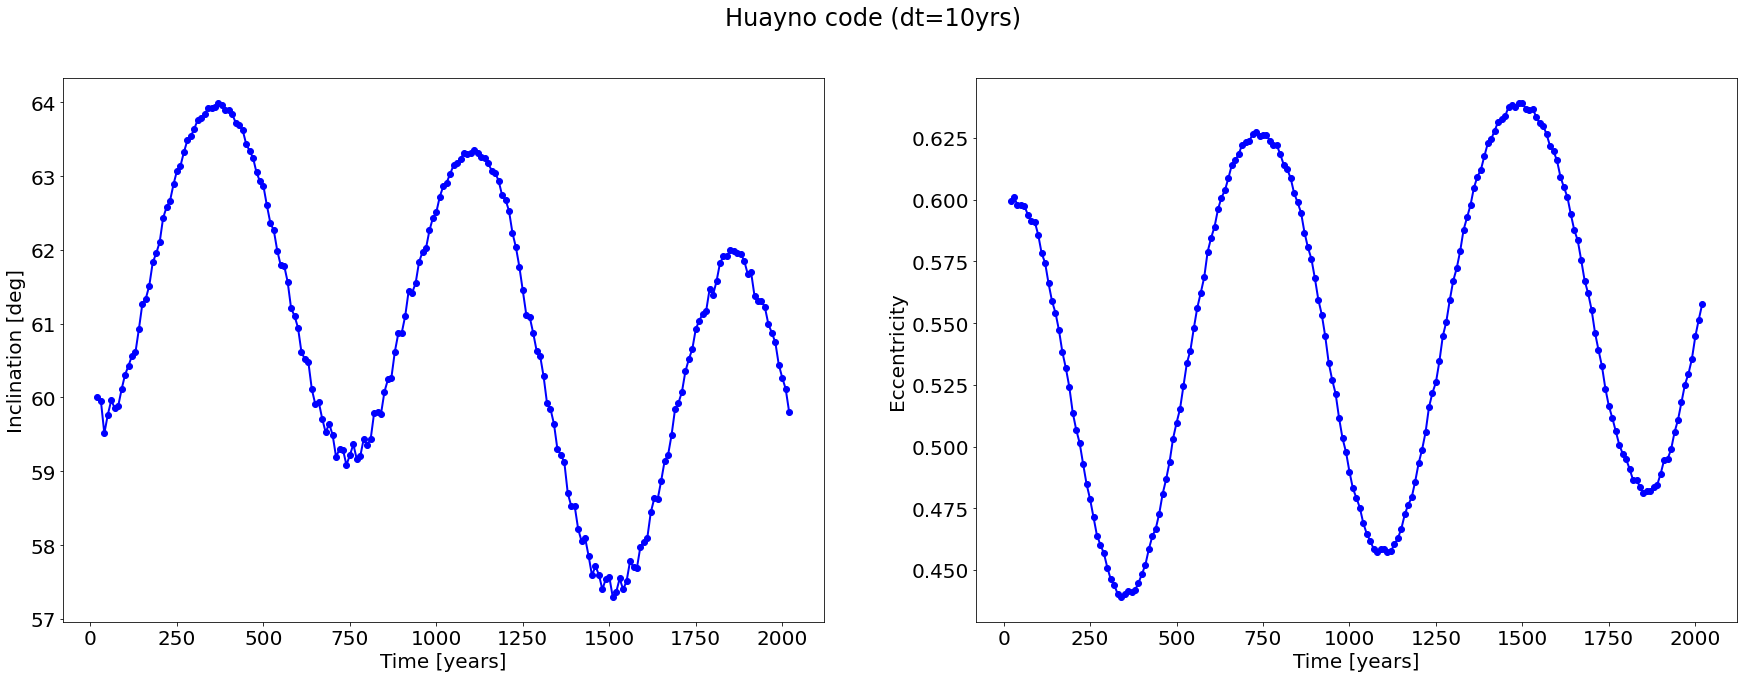

In [52]:
plot_track(ecc, inc, time)